In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import sys
from sklearn.metrics import r2_score


sys.path.append("src")
from utils import load_fred_csv
from utils import display_correlation_matrix
from utils import trend_accuracy

- `unemployment_rate` : Taux de chômage mensuel aux États-Unis, mesurant la proportion de la population active sans emploi.

- `fed_rate` : Taux d’intérêt effectif des fonds fédéraux, principal outil de politique monétaire de la Fed.

- `nfp` : Nombre total d’emplois dans le secteur non agricole aux États-Unis, indicateur clé de la création d’emplois.

- `personal_saving_rate` : Taux d’épargne personnelle des ménages américains, exprimé en pourcentage du revenu disponible.

In [3]:
unemployment_rate_path = "data/Fred_Unemployment_rate.csv"
fed_rate_path = "data/Federal_Funds_Effective_Rate.csv"
nfp_path = "data/Fred_Non_Farm_Payroll.csv"
personal_savings_path = "data/Personal_Saving_Rate.csv"

df_unemployment_rate = load_fred_csv(unemployment_rate_path, "UNRATE", "unemployment_rate") # par mois
df_nfp = load_fred_csv(nfp_path, "PAYEMS", "nfp") # par mois
df_fed_rate = load_fred_csv(fed_rate_path, "FEDFUNDS", "fed_rate") # par mois
df_personal_savings = load_fred_csv(personal_savings_path, "PSAVERT", "personal_savings") # par mois


In [4]:
# Fusion de toutes les séries sur la date
df_employment = df_fed_rate \
    .merge(df_unemployment_rate, on="date", how="inner") \
    .merge(df_nfp, on="date", how="inner") \
    .merge(df_personal_savings, on="date", how="inner")  


In [5]:
# Création des variables dérivées (% d'évolution mensuelle)
df_employment["fed_rate_growth"] = df_employment["fed_rate"].pct_change() * 100
df_employment["unemployment_rate_growth"] = df_employment["unemployment_rate"].pct_change() * 100
df_employment["nfp_growth"] = df_employment["nfp"].pct_change() * 100
df_employment["personal_saving_growth"] = df_employment["personal_savings"].pct_change() * 100

# Nettoyage : supprimer les lignes avec NaN (dus aux pct_change ou lag)
df_employment = df_employment.dropna().reset_index(drop=True)

In [6]:
df_employment

date  fed_rate  unemployment_rate     nfp  personal_savings  \
0   1959-02-01      2.43                5.9   52688              10.6   
1   1959-03-01      2.80                5.6   53014              10.3   
2   1959-04-01      2.96                5.2   53321              11.2   
3   1959-05-01      2.90                5.1   53550              10.6   
4   1959-06-01      3.39                5.0   53681              10.5   
..         ...       ...                ...     ...               ...   
786 2024-08-01      5.33                4.2  158074               4.4   
787 2024-09-01      5.13                4.1  158314               4.1   
788 2024-10-01      4.83                4.1  158358               4.3   
789 2024-11-01      4.64                4.2  158619               4.1   
790 2024-12-01      4.48                4.1  158942               3.8   

     fed_rate_growth  unemployment_rate_growth  nfp_growth  \
0          -2.016129                 -1.666667    0.400168   
1          15.226337                 -5.084746    0.618737   
2           5.714286                 -7.142857    0.579092   
3          -2.027027                 -1.923077    0.429474   
4          16.896552                 -1.960784    0.244631   
..               ...                       ...         ...   
786         0.000000                  0.000000    0.044936   
787        -3.752345                 -2.380952    0.151828   
788        -5.847953                  0.000000    0.027793   
789        -3.933747                  2.439024    0.164816   
790        -3.448276                 -2.380952    0.203633   

     personal_saving_growth  
0                 -6.194690  
1                 -2.830189  
2                  8.737864  
3                 -5.357143  
4                 -0.943396  
..                      ...  
786                0.000000  
787               -6.818182  
788                4.878049  
789               -4.651163  
790               -7.317073  

[791 rows x 9 columns]

In [7]:
# Sélectionner les colonnes numériques à standardiser (hors "date")
cols_to_standardize = [
    "fed_rate",
    "unemployment_rate",
    "nfp",
    "personal_savings",
    "fed_rate_growth",
    "unemployment_rate_growth",
    "nfp_growth",
    "personal_saving_growth"
]

# Standardisation (z-score)
scaler = StandardScaler()
df_std = df_employment[["date"]].copy()
df_std[cols_to_standardize] = scaler.fit_transform(df_employment[cols_to_standardize])

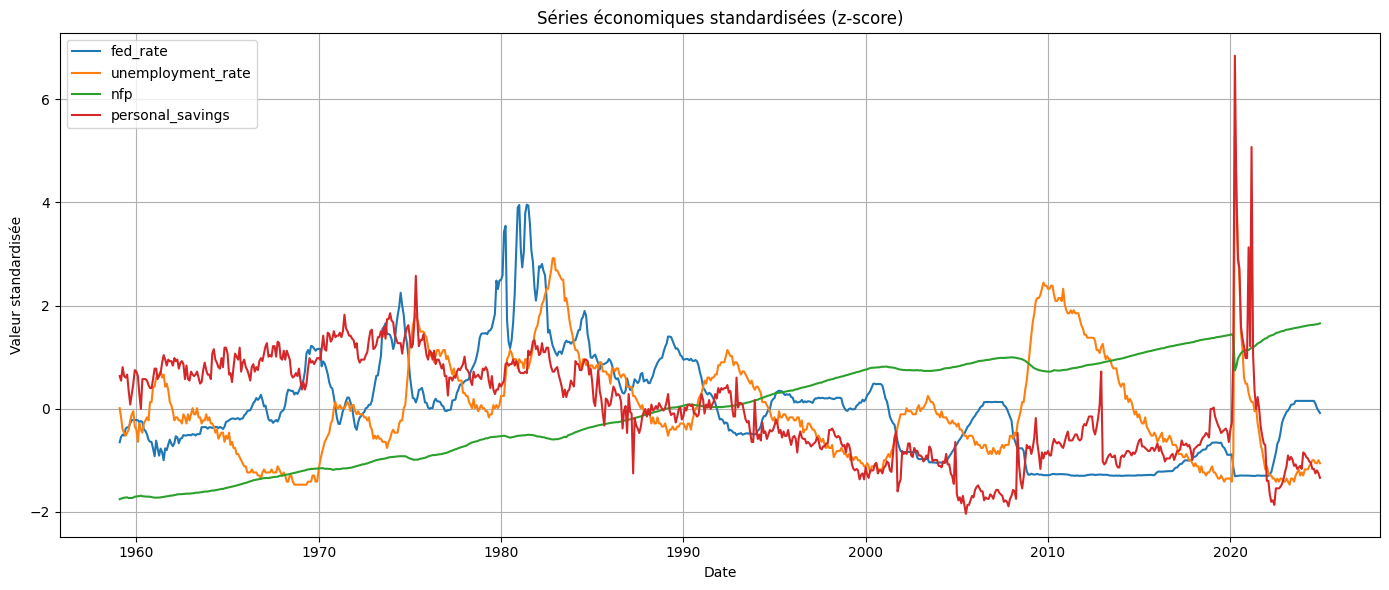

In [8]:
cols_to_plot = ["fed_rate", "unemployment_rate", "nfp", "personal_savings"]

plt.figure(figsize=(14, 6))
for col in cols_to_plot:
    plt.plot(df_std["date"], df_std[col], label=col)

plt.title("Séries économiques standardisées (z-score)")
plt.xlabel("Date")
plt.ylabel("Valeur standardisée")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

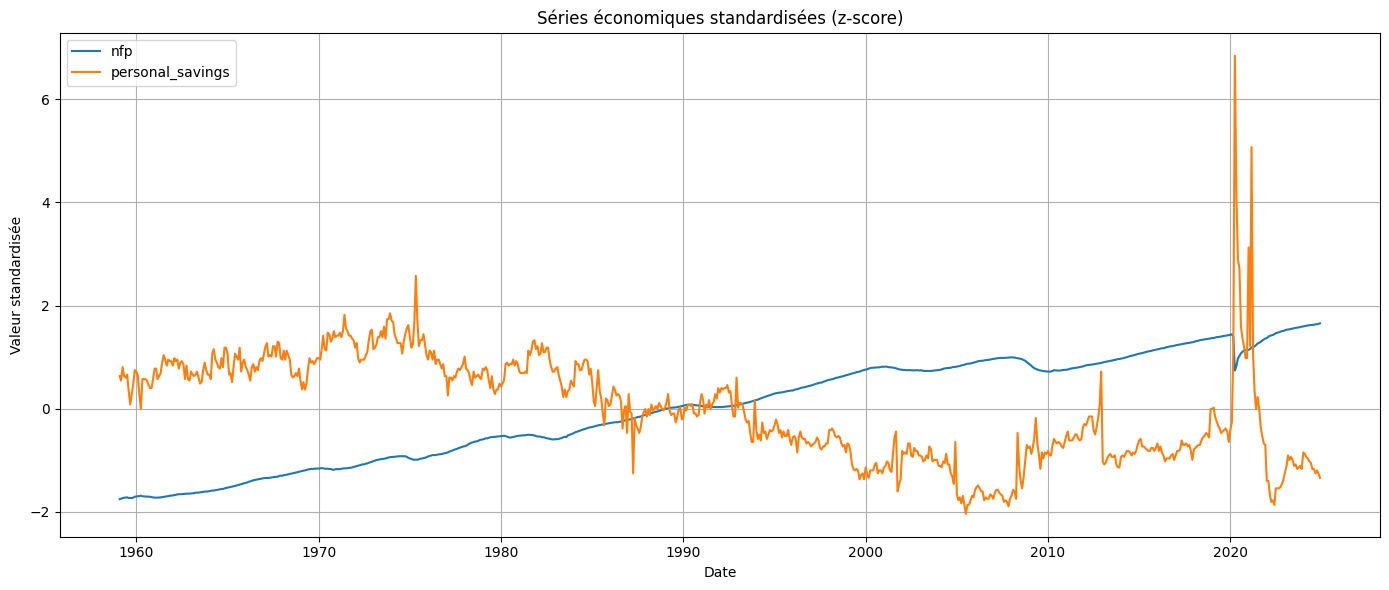

In [9]:
cols_to_plot = ["nfp", "personal_savings"]

plt.figure(figsize=(14, 6))
for col in cols_to_plot:
    plt.plot(df_std["date"], df_std[col], label=col)

plt.title("Séries économiques standardisées (z-score)")
plt.xlabel("Date")
plt.ylabel("Valeur standardisée")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

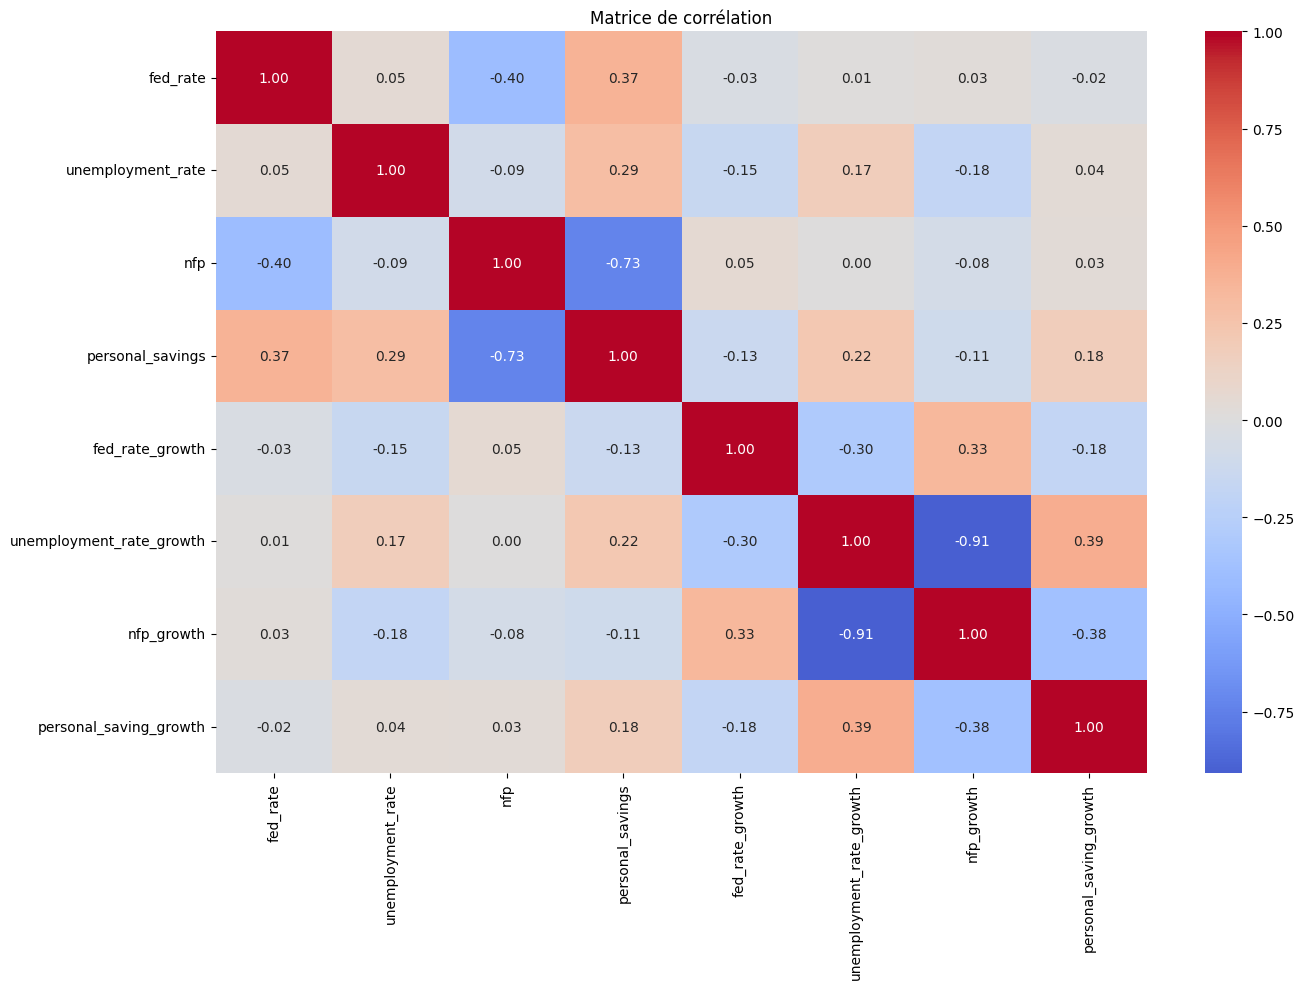

In [10]:
display_correlation_matrix(df_std, "Matrice de corrélation", figsize=(14, 10))

### Analyse de corrélation :

- `nfp` (emploi non agricole) vs `personal_savings` : **-0.73**

> Plus l'emploi augmente, plus le taux d'épargne baisse. Cela peut refléter une confiance accrue des ménages en période de bonne santé économique, menant à moins d’épargne et plus de consommation.

- `unemployment_rate_growth` vs `nfp_growth` : **-0.91**

> Quand la création d’emplois augmente, le taux de chômage baisse (et inversement).

- `fed_rate` vs `nfp` : **-0.40**

> Taux directeurs élevés sont modérément associés à une baisse de l’emploi. Cela soutient notre hypothèse : des taux élevés freinent l’embauche.

- `fed_rate` vs `personal_savings` : **0.37**

> Lorsque les taux montent, les gens ont tendance à épargner davantage (comportement de précaution ou rendements plus élevés).

- `personal_savings` vs `unemployment_rate` : **0.29**

> En période de chômage plus élevé, l'épargne peut augmenter : soit par réduction des dépenses, soit par comportement prudent.

- `fed_rate_growth` vs `unemployment_rate_growth` : **-0.30**

> Cela signifie qu’une hausse des taux est légèrement associée à une baisse de la croissance du chômage. C’est surprenant, car on s’attend généralement à ce que des taux plus élevés freinent l’activité économique, ce qui devrait au contraire faire augmenter le chômage. Mais il se peut que la réaction du chômage soit décalée dans le temps → une analyse en décalé (lag) serait plus pertinente ici.

`unemployment_rate_growth` vs `personal_saving_growth` : **0.39**

> Quand le chômage augmente rapidement, l’épargne aussi → comportement défensif des ménages.

- `nfp_growth` vs `personal_saving_growth` : **-0.38**
> Plus de créations d’emplois → moins d’épargne (logique, comme observé plus haut).

In [11]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Copie de base du DataFrame initial
df_base = df_employment.copy()

# Colonnes à décaler
cols_to_lag = [
    "fed_rate",
    "unemployment_rate",
    "nfp",
    "personal_savings",
    "fed_rate_growth",
    "unemployment_rate_growth",
    "nfp_growth",
    "personal_saving_growth"
]

# Dictionnaire des types de lags
lag_dict = {
    "short": [3, 6, 12],
    "medium": [16, 24, 30],
    "long": [36, 42, 48],
    "very_long": [54, 60, 66]
}

# Fonction pour générer un DataFrame avec lags + standardisation
def create_lagged_df(df, lag_list, name=None):
    df_lagged = df.copy()
    
    # Création des colonnes décalées
    for col in cols_to_lag:
        for lag in lag_list:
            df_lagged[f"{col}_lag{lag}"] = df_lagged[col].shift(lag)
    
    # Nettoyage des NaN
    df_lagged = df_lagged.dropna().reset_index(drop=True)
    
    # Colonnes à standardiser
    features_to_standardize = [col for col in df_lagged.columns if "lag" in col]
    features_to_standardize += cols_to_lag

    # Standardisation
    scaler = StandardScaler()
    df_std = df_lagged[["date"]].copy()
    df_std[features_to_standardize] = scaler.fit_transform(df_lagged[features_to_standardize])

    return df_std

# Création des trois DataFrames
df_employment_short = create_lagged_df(df_base, lag_dict["short"], "short")
df_employment_medium = create_lagged_df(df_base, lag_dict["medium"], "medium")
df_employment_long = create_lagged_df(df_base, lag_dict["long"], "long")
df_employment_very_long = create_lagged_df(df_base, lag_dict["very_long"], "very_long")


we need to pay attention to data leakage here, the standard scalar should not be fitted to test data.

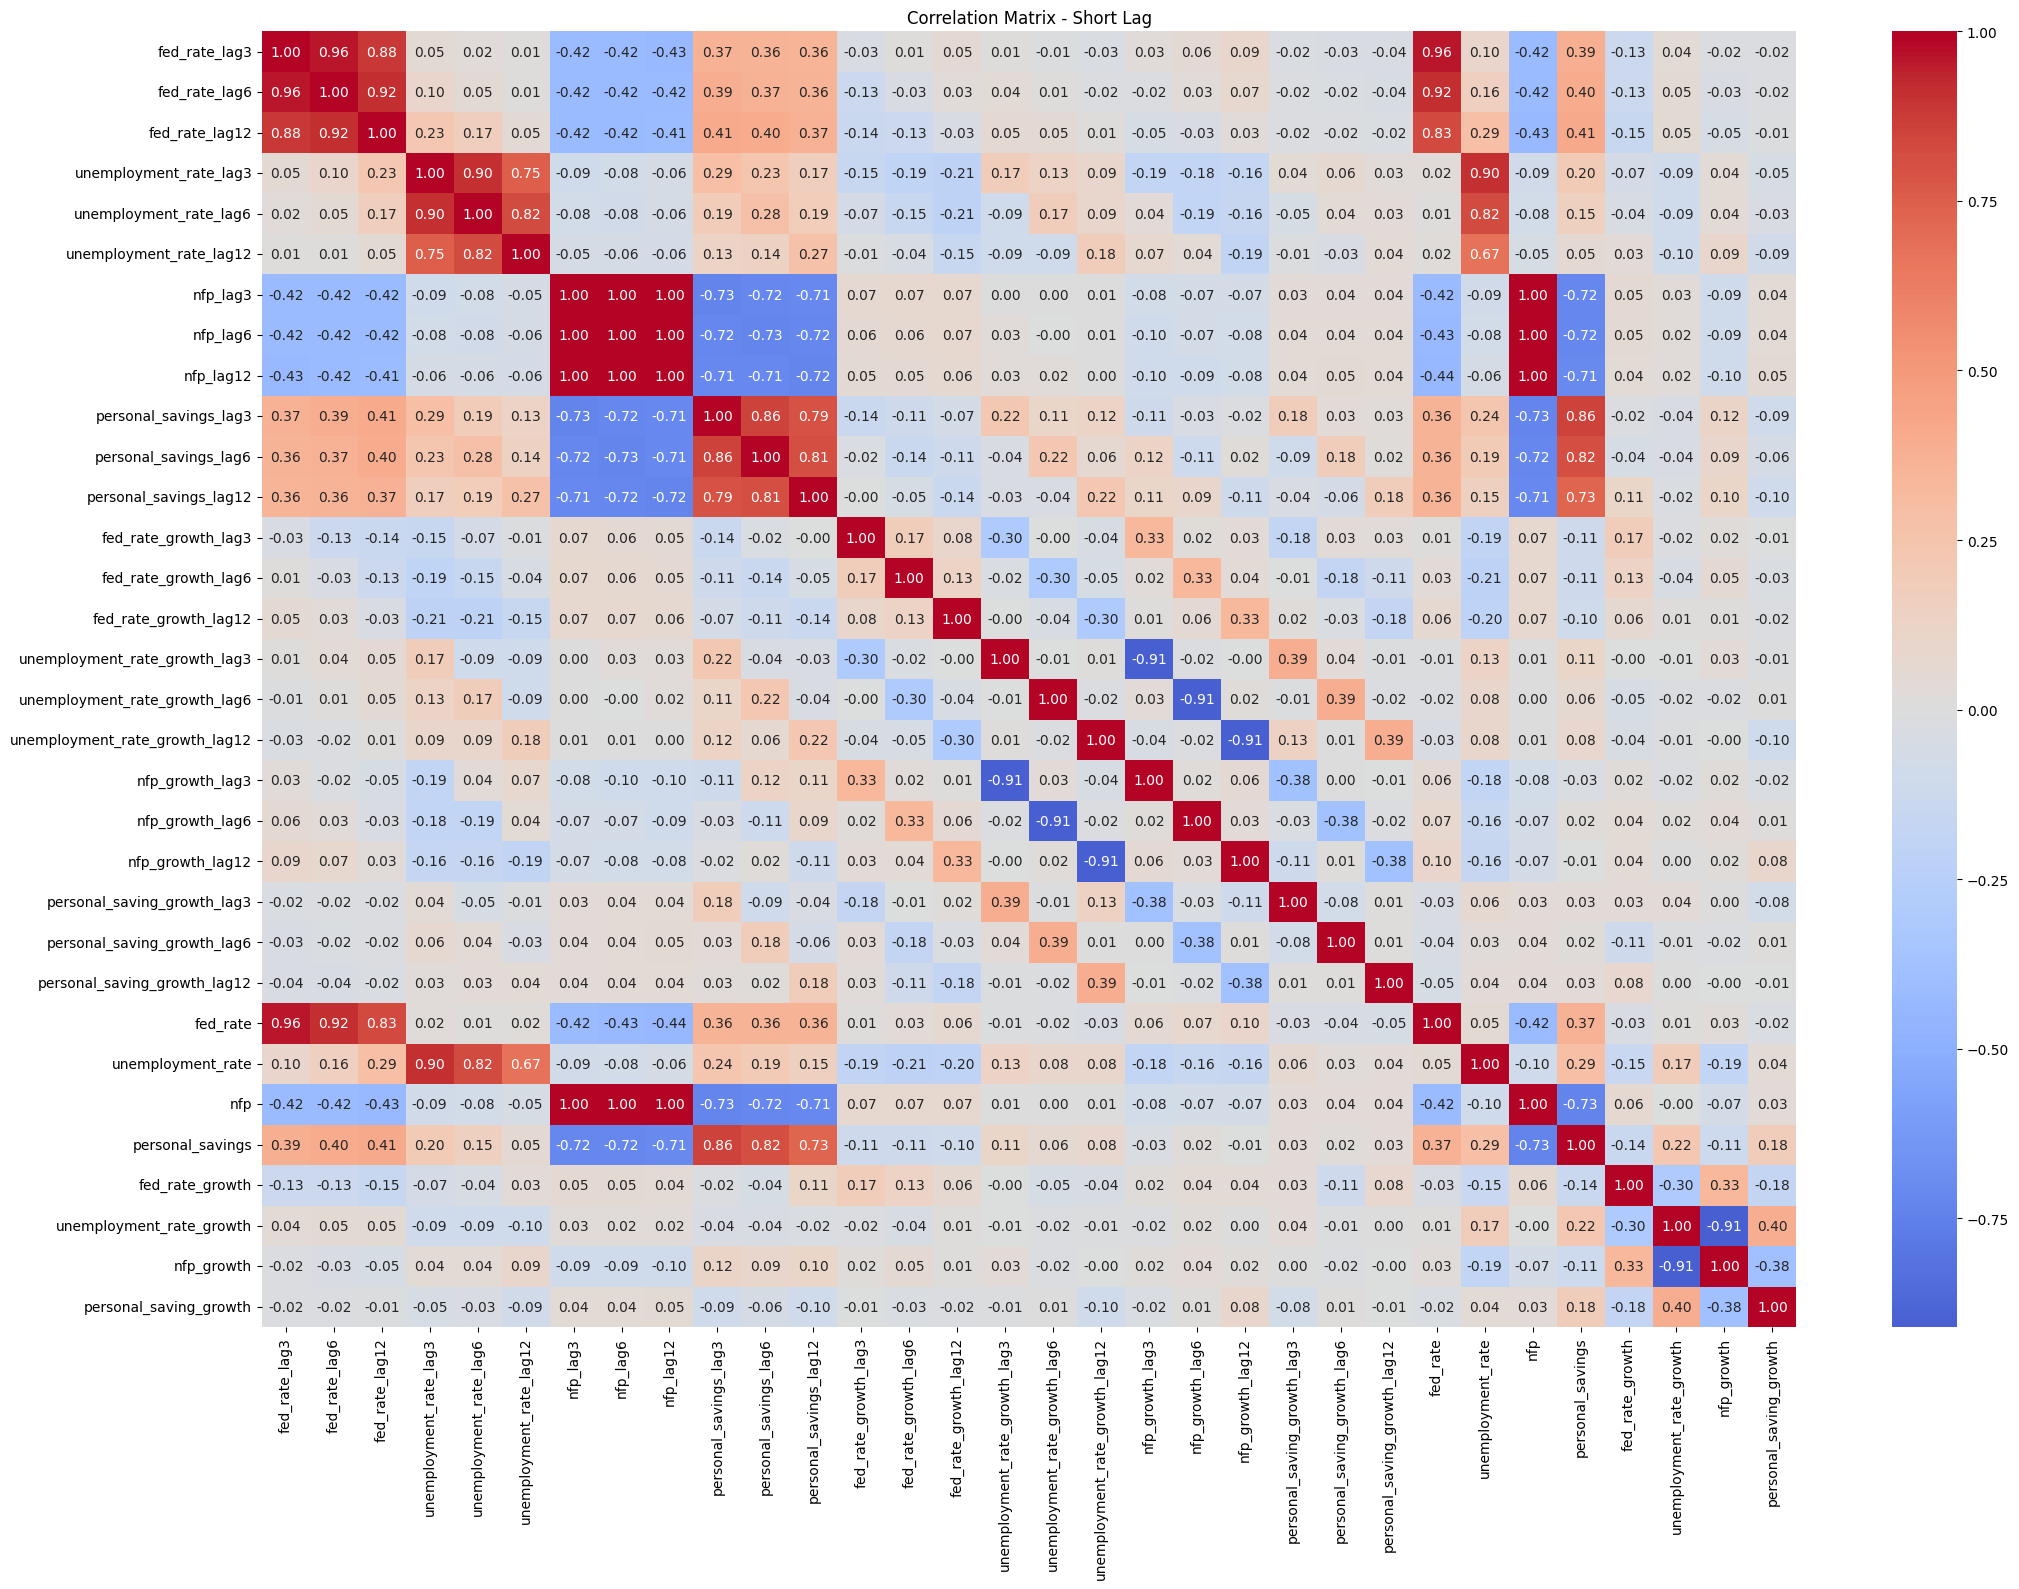

In [12]:
display_correlation_matrix(df_employment_short, "Correlation Matrix - Short Lag", figsize=(22, 16))

Attention! Pour éviter de se perdre dans ces grosses matrices on regarde juste les colonnes des variables initiales non décalées. Parce que si X_lag_3 est corrélée avec Y_lag_6, alors X est corrélé avec Y_lag_3.

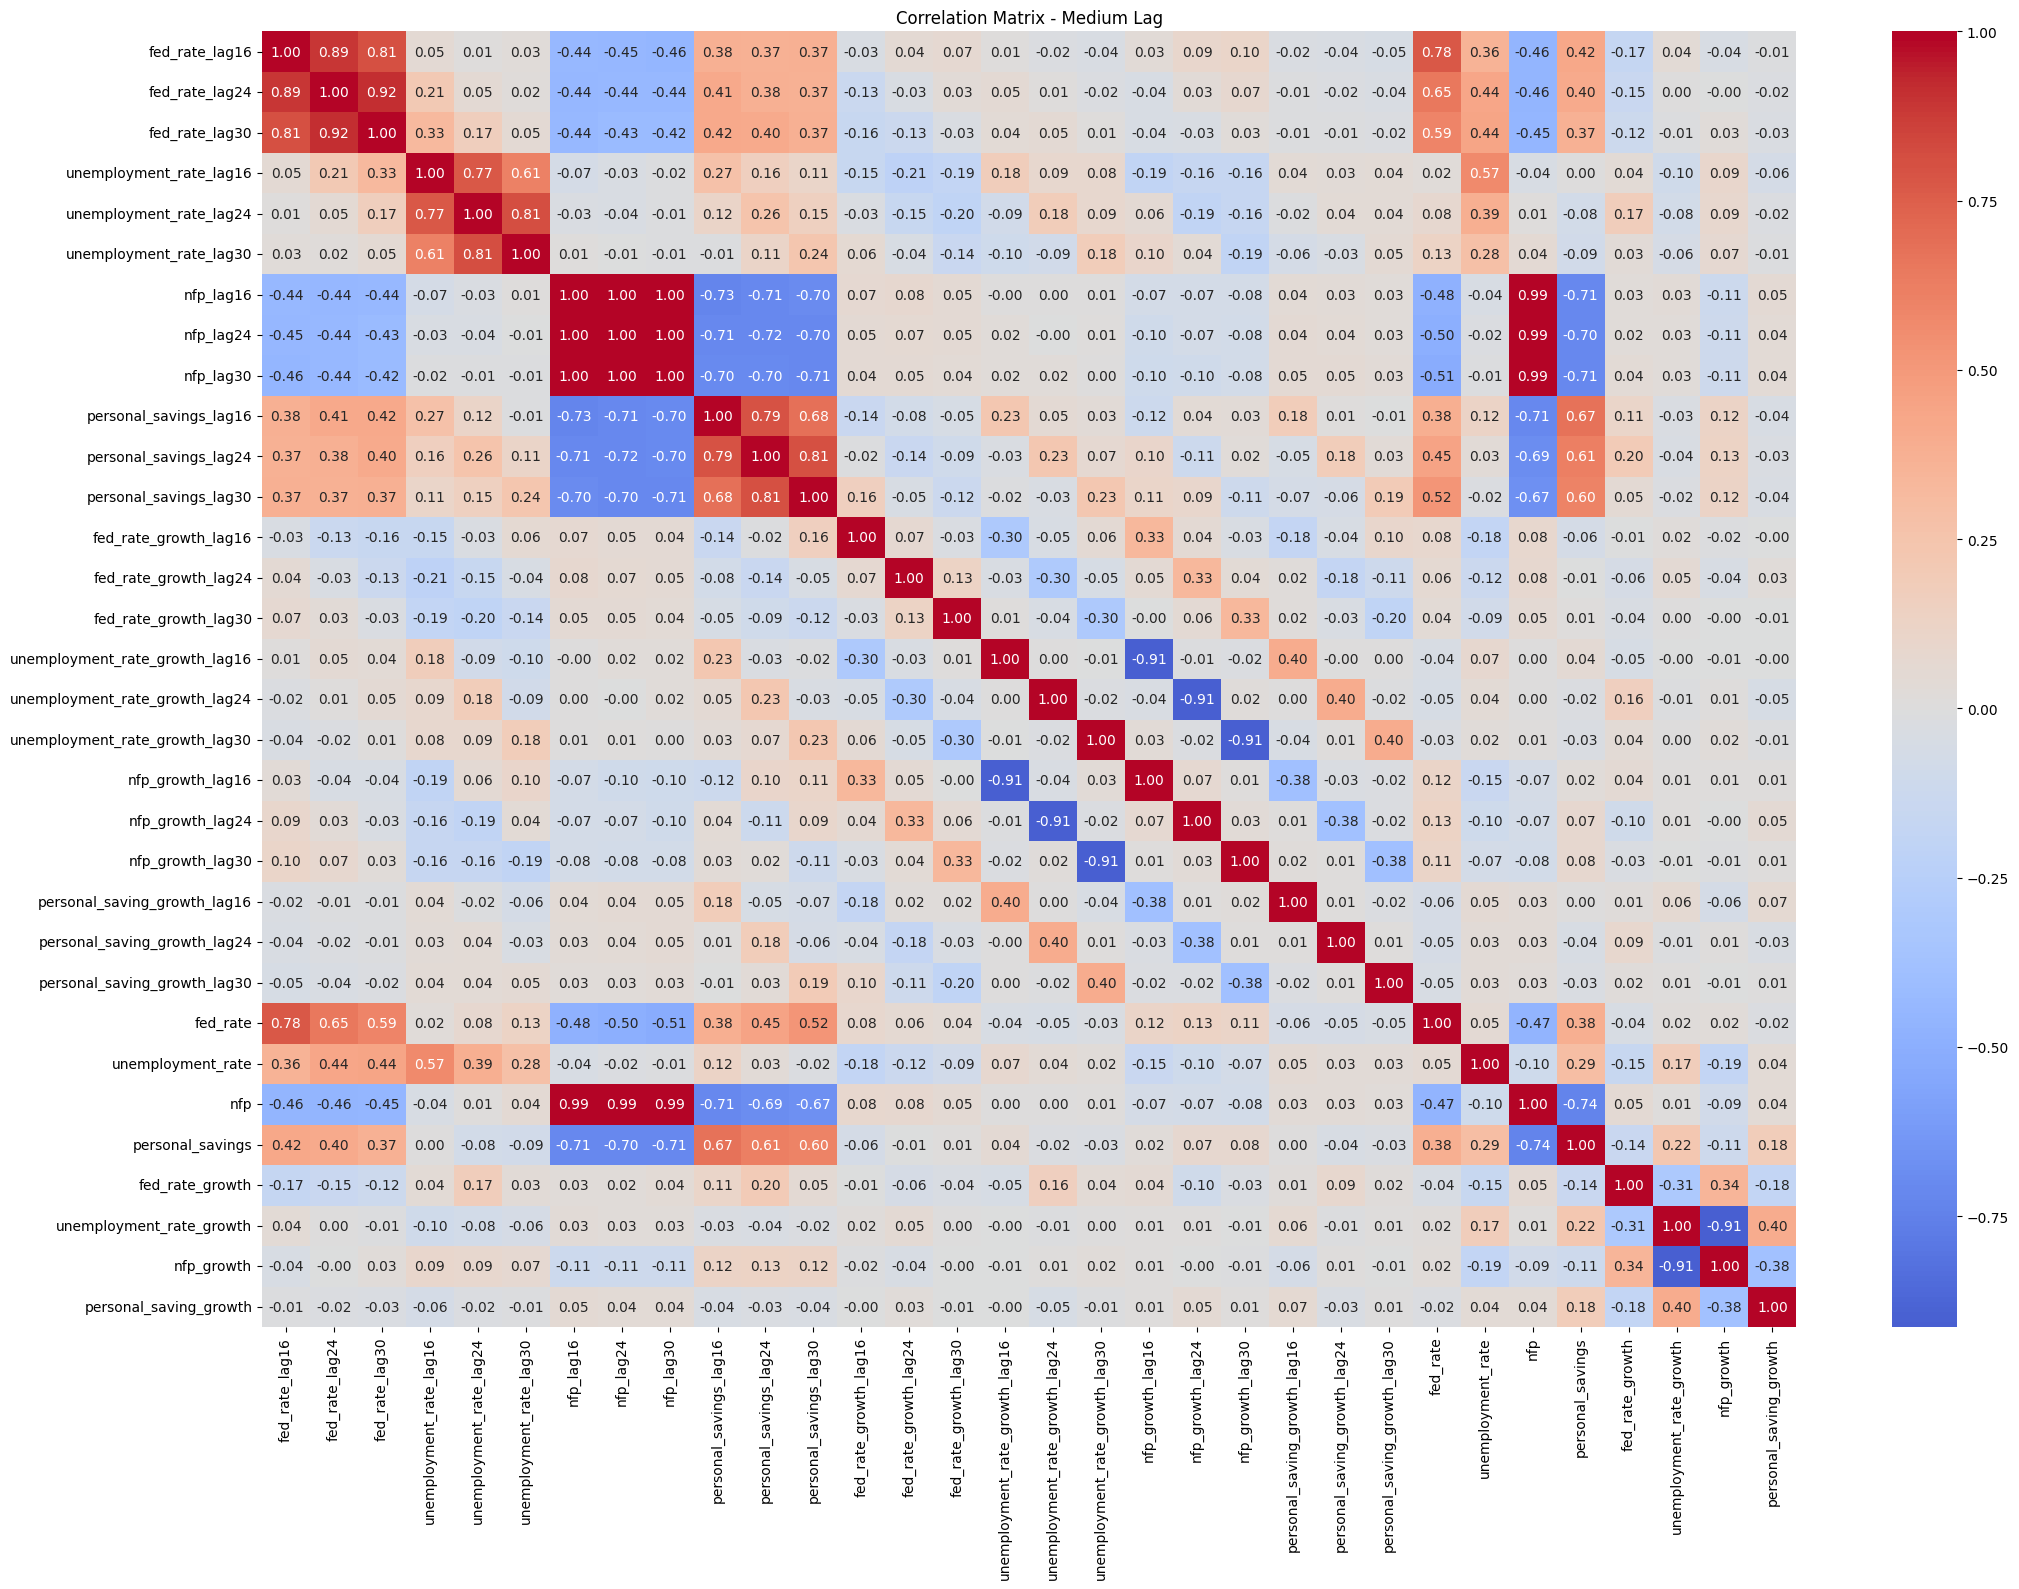

In [13]:
# testons des lags plus longs pour voir si on a plus de corrélations
display_correlation_matrix(df_employment_medium, "Correlation Matrix - Medium Lag", figsize=(22, 16))

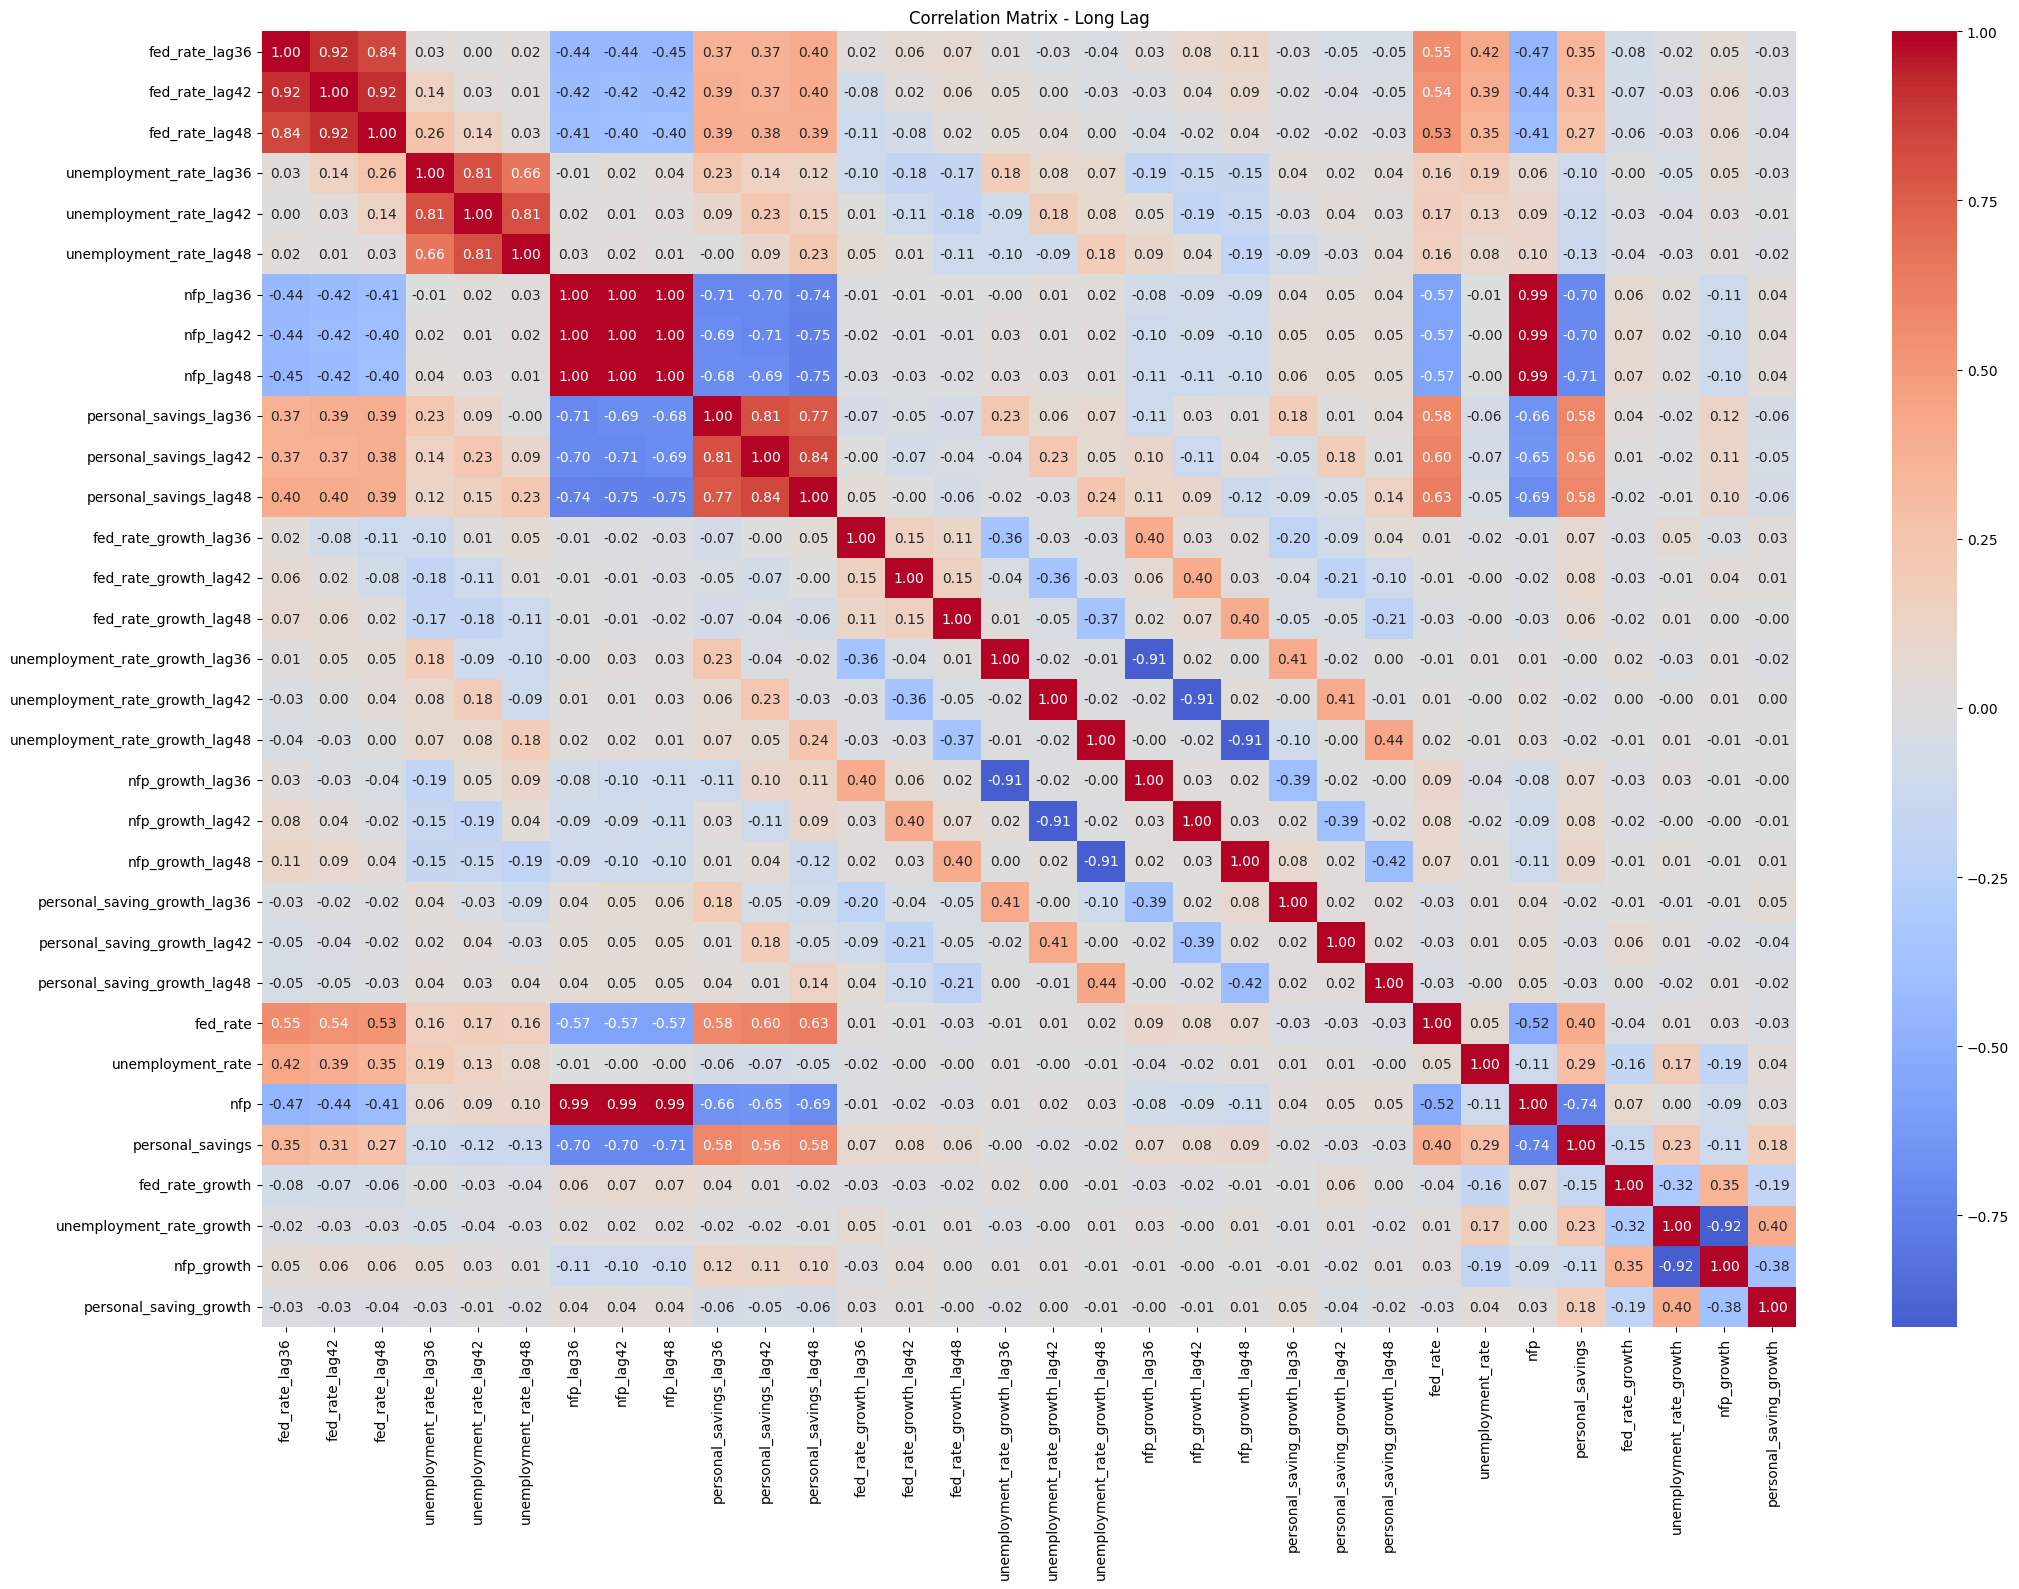

In [14]:
display_correlation_matrix(df_employment_long, "Correlation Matrix - Long Lag", figsize=(22,16))

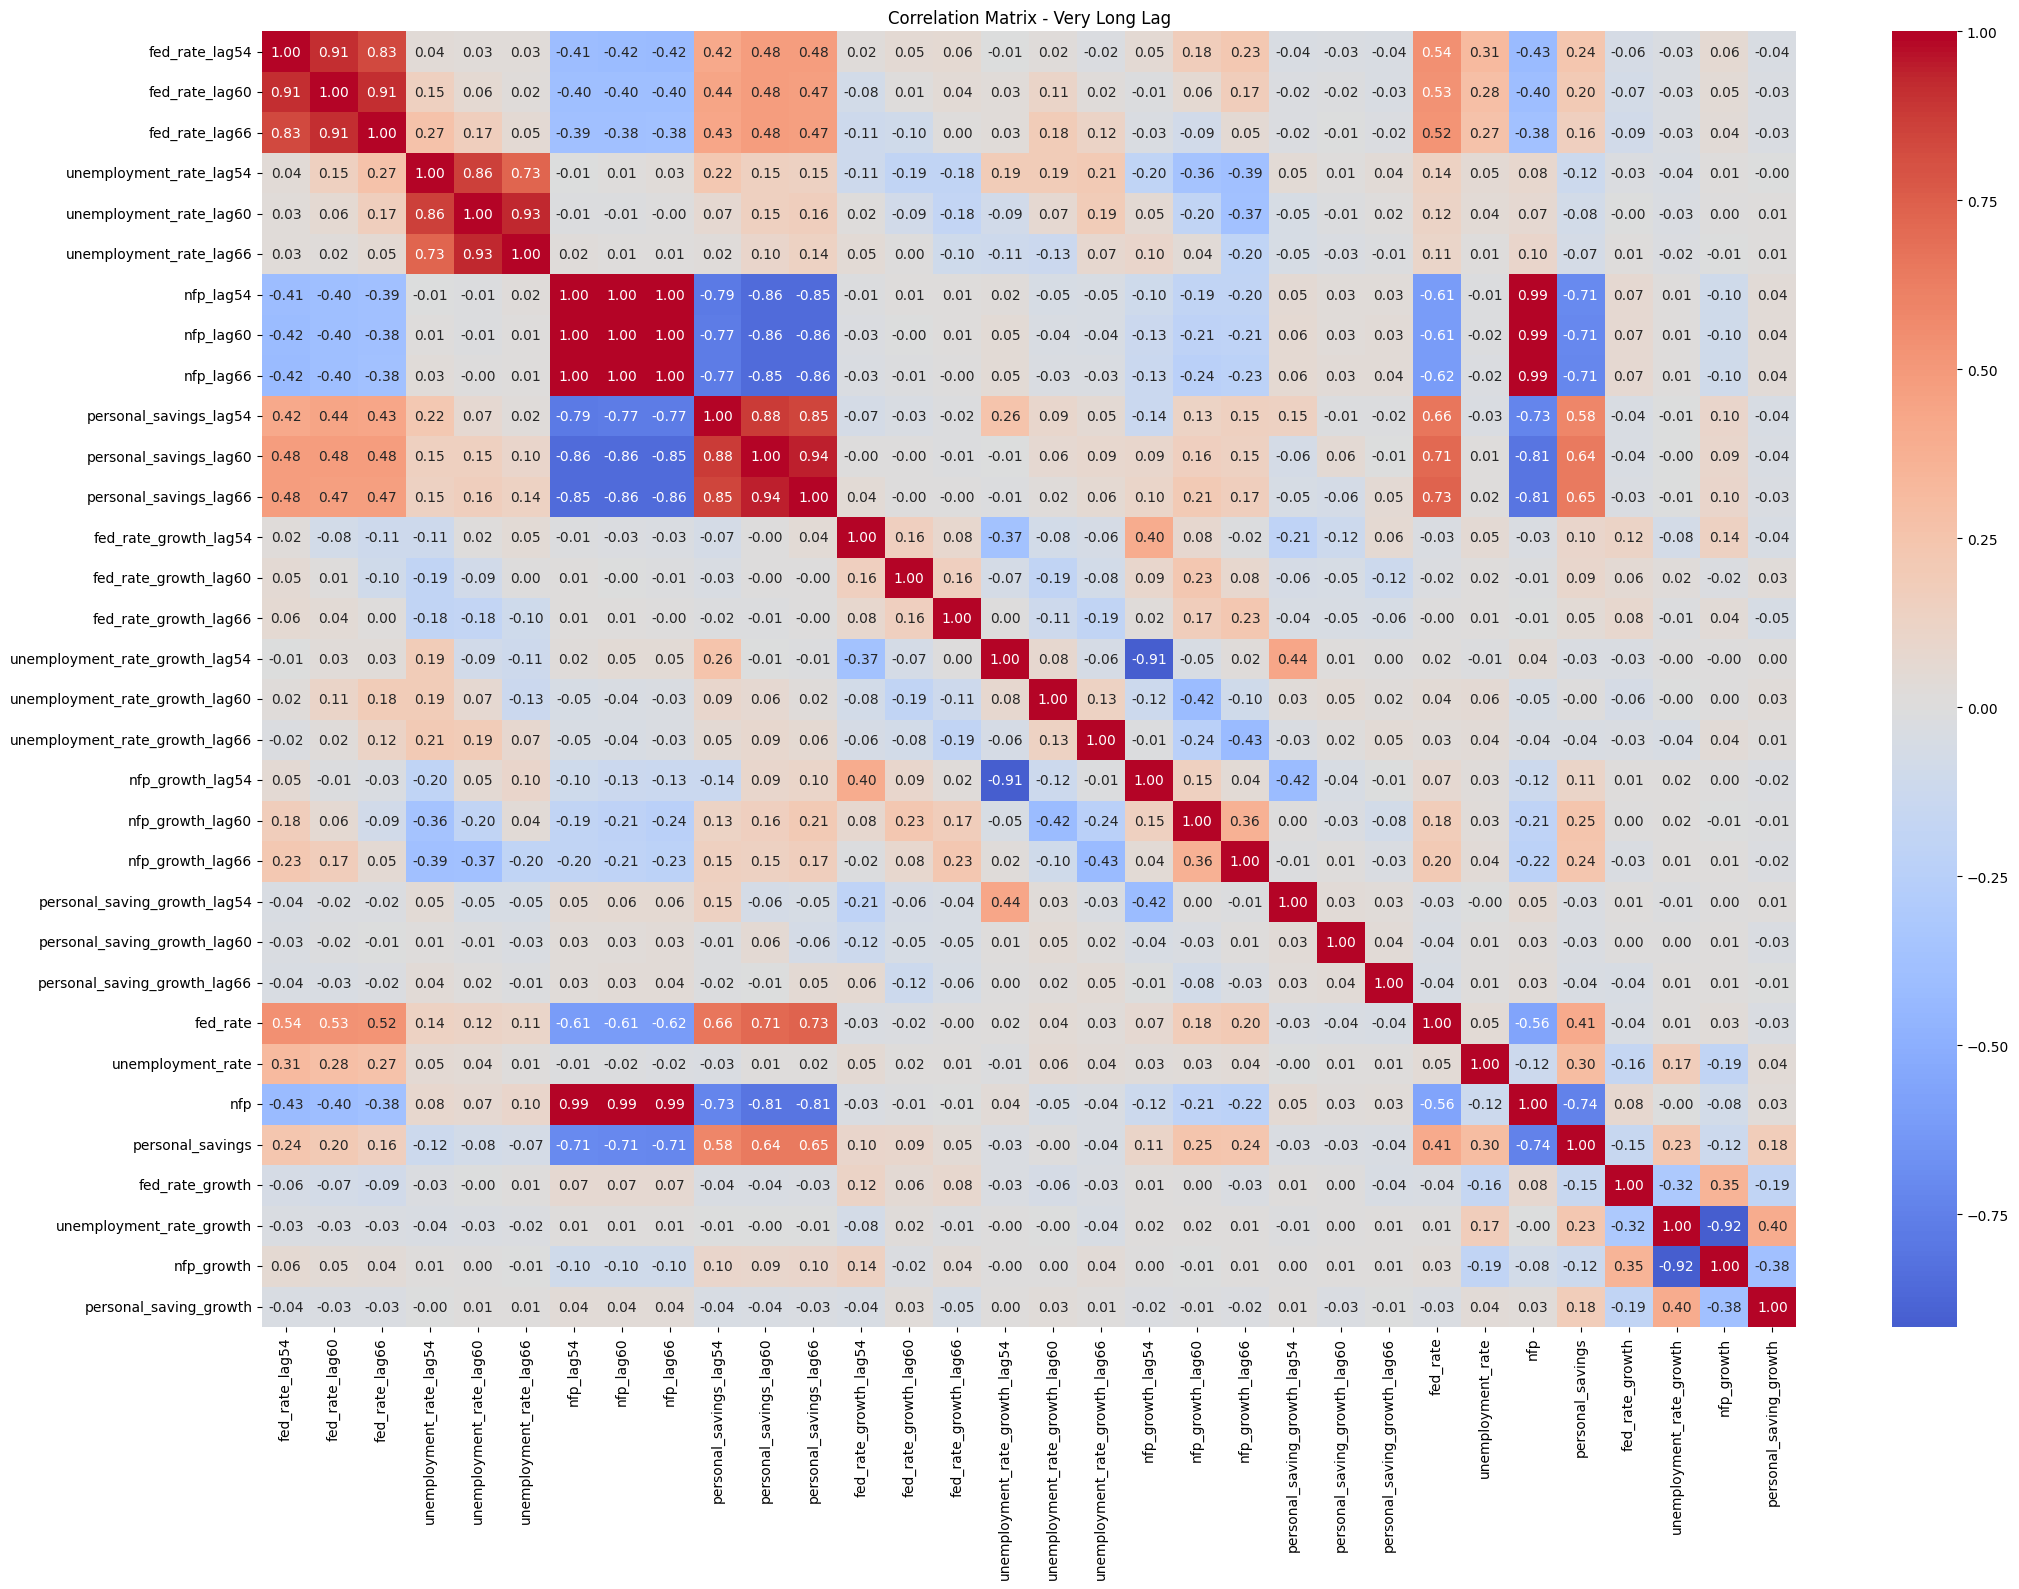

In [15]:
display_correlation_matrix(df_employment_very_long, "Correlation Matrix - Very Long Lag", figsize=(22,16))

### Analyse Finale

- `Unemployment Rate` :

    * Auto : lag3 = **0.90**, lag6 = **0.82**, lag12 = **0.67** → forte inertie.

    * `personal_saving` : **0.29** → plus de chômage = plus d’épargne.

    * `fed_rate_lag24` : **0.44** → taux élevés → hausse du chômage après **2 ans**.

    > Le chômage réagit lentement aux conditions économiques, avec un effet visible des taux d’intérêt seulement après deux ans.

- `nfp` (Nonfarm Payrolls) :

    * `personal_saving` : **-0.73** → plus d’emplois = moins d’épargne.

    * Auto : lag3 = **1**, lag6 = **1**, lag12 = **0.99** → très persistante.

    * `fed_rate_lag24` : **0.46** → contre-intuitif
    > L’emploi évolue de manière très stable et réagit faiblement mais positivement aux taux élevés avec un long délai.

- `personal_savings` :
    * Auto : lag3 = **0.86**, lag6 = **0.82**, lag12 = **0.73**, lag16 = **0.67** → très persistante.

    * `fed_rate` : **0.37** → taux élevés → + d’épargne.
    >  L’épargne est très stable dans le temps et augmente environ un an après une hausse des taux, par effet de précaution ou d’incitation.

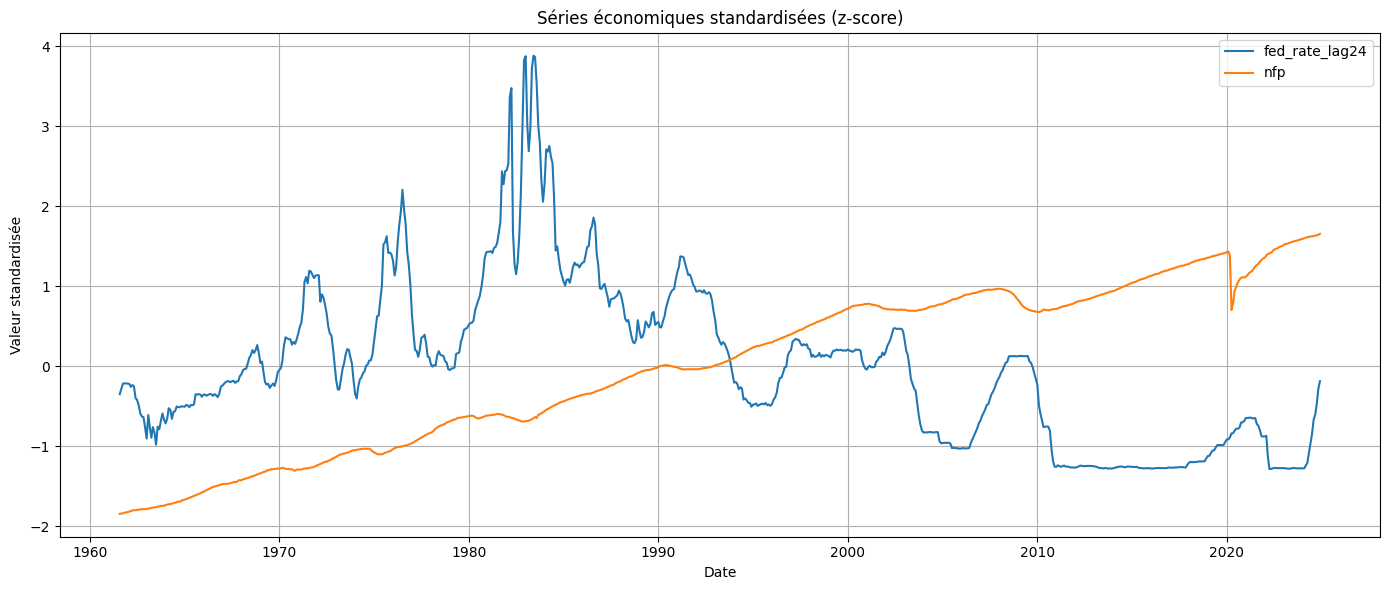

In [16]:
cols_to_plot = ["fed_rate_lag24", "nfp"]

plt.figure(figsize=(14, 6))
for col in cols_to_plot:
    plt.plot(df_employment_medium["date"], df_employment_medium[col], label=col)

plt.title("Séries économiques standardisées (z-score)")
plt.xlabel("Date")
plt.ylabel("Valeur standardisée")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

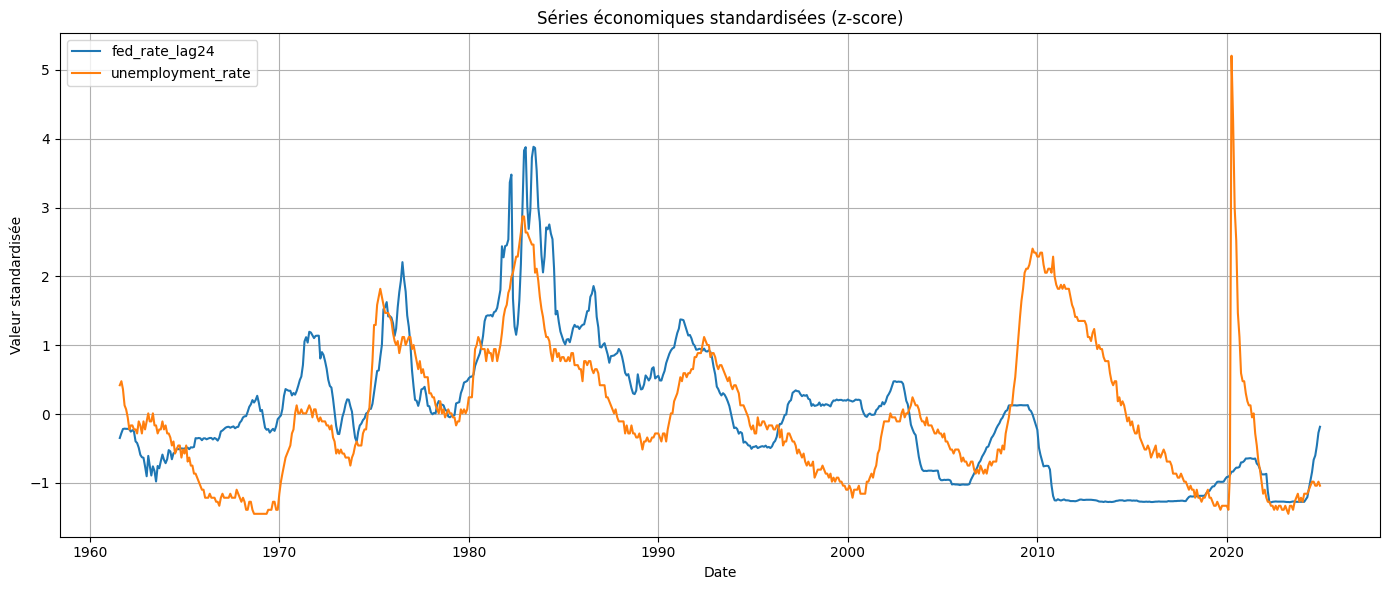

In [25]:
cols_to_plot = ["fed_rate_lag24", "unemployment_rate"]

plt.figure(figsize=(14, 6))
for col in cols_to_plot:
    plt.plot(df_employment_medium["date"], df_employment_medium[col], label=col)

plt.title("Séries économiques standardisées (z-score)")
plt.xlabel("Date")
plt.ylabel("Valeur standardisée")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Contrairement à ce qu'on a eu dans l'étude de correlation précedemment, quand le taux directeur (décalé de 2 ans) augmente, la courbe du NFP ralentit légèrement voire s’aplatit.

Exemples :
Année 1970
Années 1974-1975
Années 1979-1981
Années 1990-1992
Années 2003-2006

Cela renforce notre hypothèse.

# Modèle prédictif

In [17]:
import statsmodels.api as sm

df_temp = df_employment[["fed_rate", "unemployment_rate", "personal_savings"]].copy()

# Création de la variable décalée
df_temp["fed_rate_lag24"] = df_temp["fed_rate"].shift(24)

# On retire les lignes avec des NaN
df_model = df_temp[["fed_rate_lag24", "unemployment_rate", "personal_savings"]].dropna()

# Variables X et y
y = df_model["unemployment_rate"]
X = df_model[["personal_savings", "fed_rate_lag24"]]

# Ajout d'une constante (intercept)
X = sm.add_constant(X)

# Régression linéaire
model = sm.OLS(y, X).fit()

# Résumé
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:      unemployment_rate   R-squared:                       0.206
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     99.14
Date:                Fri, 16 May 2025   Prob (F-statistic):           5.24e-39
Time:                        00:29:20   Log-Likelihood:                -1410.6
No. Observations:                 767   AIC:                             2827.
Df Residuals:                     764   BIC:                             2841.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                4.4736      0.145  

# Evaluation

In [21]:
# Dates dans lesquelles on va tester la régression (on prend les 20% dernières années de chaque période pour le test)
periods = [
    ("1989-01-01", "2000-01-01"),
    ("2000-01-01", "2010-01-01"),
    ("2005-01-01", "2015-01-01"),
    ("2010-01-01", "2020-01-01"),
    ("2015-01-01", "2025-01-01")
]

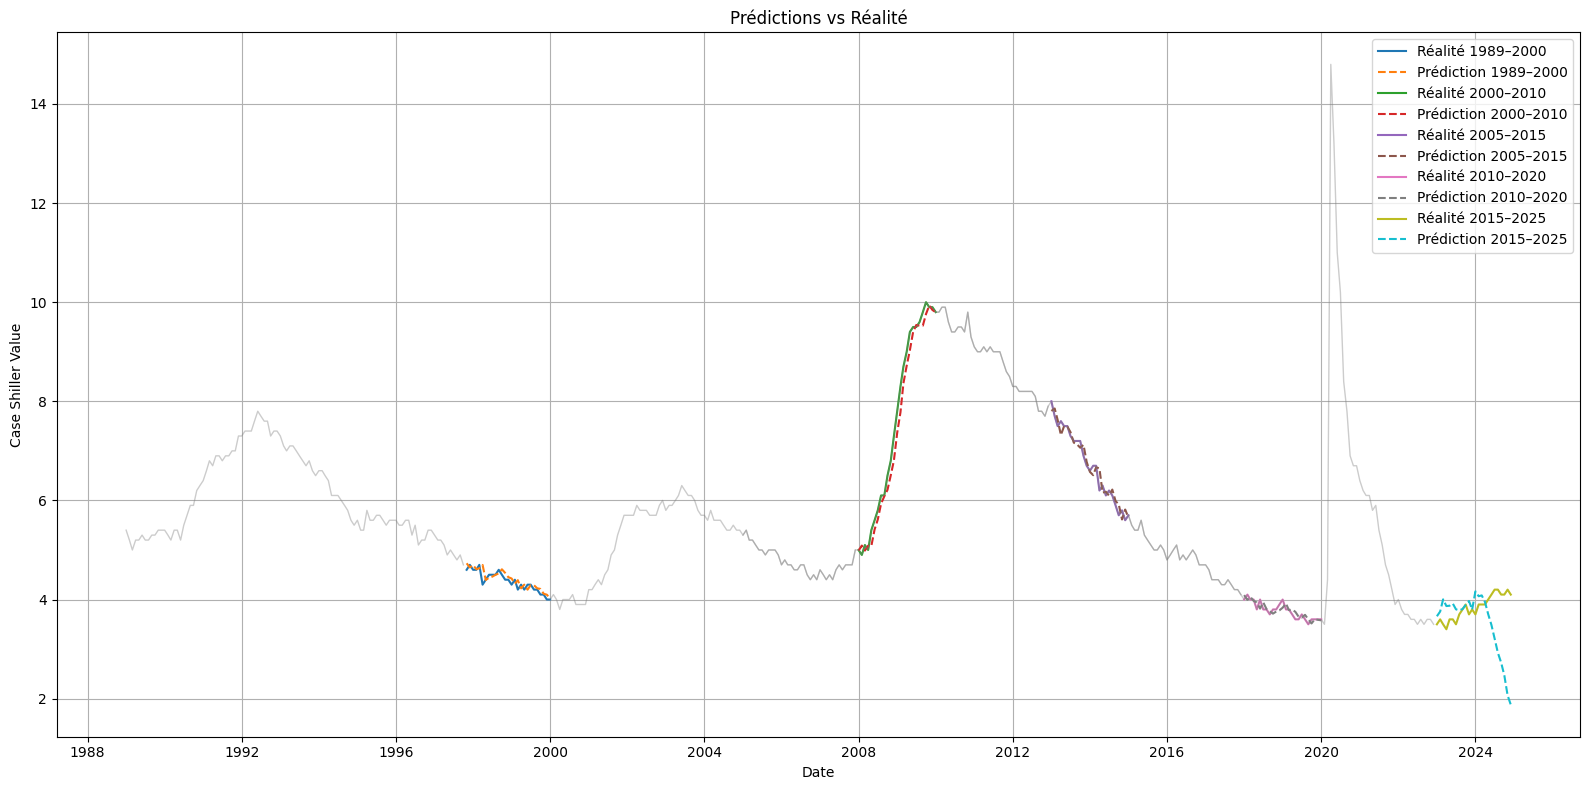

R² moyen du modèle : -1.6265
Taux de tendance moyen du modèle : 0.3728


In [22]:
# Préparation du DataFrame avec lags
df_temp = df_employment[["date", "fed_rate", "unemployment_rate", "personal_savings"]].copy()
df_temp["fed_rate_lag24"] = df_temp["fed_rate"].shift(24)

for lag in range(1, 25):
    df_temp[f"unemployment_rate_lag{lag}"] = df_temp["unemployment_rate"].shift(lag)

# Supprimer les lignes incomplètes
df_model = df_temp.dropna().reset_index(drop=True)

random_state = 42
# Set the random seed for reproducibility
np.random.seed(random_state)

# Liste pour stocker les R²
r2_scores_macro = []
trend_scores_macro = []

# Plot
plt.figure(figsize=(16, 8))
plt.title("Prédictions vs Réalité")
plt.xlabel("Date")
plt.ylabel("Case Shiller Value")

for start_date, end_date in periods:
    # Filtrage de la période
    period_df = df_model[(df_model["date"] >= start_date) & (df_model["date"] <= end_date)].copy()
    
    # Split train/test (80% train, 20% test)
    split_idx = int(len(period_df) * 0.8)
    train = period_df.iloc[:split_idx]
    test = period_df.iloc[split_idx:]

    # Y et X
    y_train = train["unemployment_rate"]
    X_train = train[["fed_rate_lag24", "personal_savings"]+[f"unemployment_rate_lag{lag}" for lag in range(1, 7)]]
    X_train = sm.add_constant(X_train)

    y_test = test["unemployment_rate"]
    X_test = test[["fed_rate_lag24", "personal_savings"]+[f"unemployment_rate_lag{lag}" for lag in range(1, 7)]]
    X_test = sm.add_constant(X_test)

    # Régression
    model = sm.OLS(y_train, X_train).fit()
    
    y_test_pred = model.predict(X_test)
    
    # Calcul du R² pour cette période
    r2 = r2_score(y_test, y_test_pred)
    r2_scores_macro.append(r2)
    trend_acc = trend_accuracy(y_test.values, y_test_pred.values)
    trend_scores_macro.append(trend_acc)

    # Tracés
    plt.plot(train["date"], y_train, color='gray', linewidth=1, alpha=0.4)
    plt.plot(test["date"], y_test, label=f"Réalité {start_date[:4]}–{end_date[:4]}")
    plt.plot(test["date"], y_test_pred, linestyle="--", label=f"Prédiction {start_date[:4]}–{end_date[:4]}")

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Moyenne du R² sur toutes les périodes
r2_model_fed_pers_unemp = np.mean(r2_scores_macro)
trend_model_fed_pers_unemp = np.mean(trend_scores_macro)
print(f"R² moyen du modèle : {r2_model_fed_pers_unemp:.4f}")
print(f"Taux de tendance moyen du modèle : {trend_model_fed_pers_unemp:.4f}")

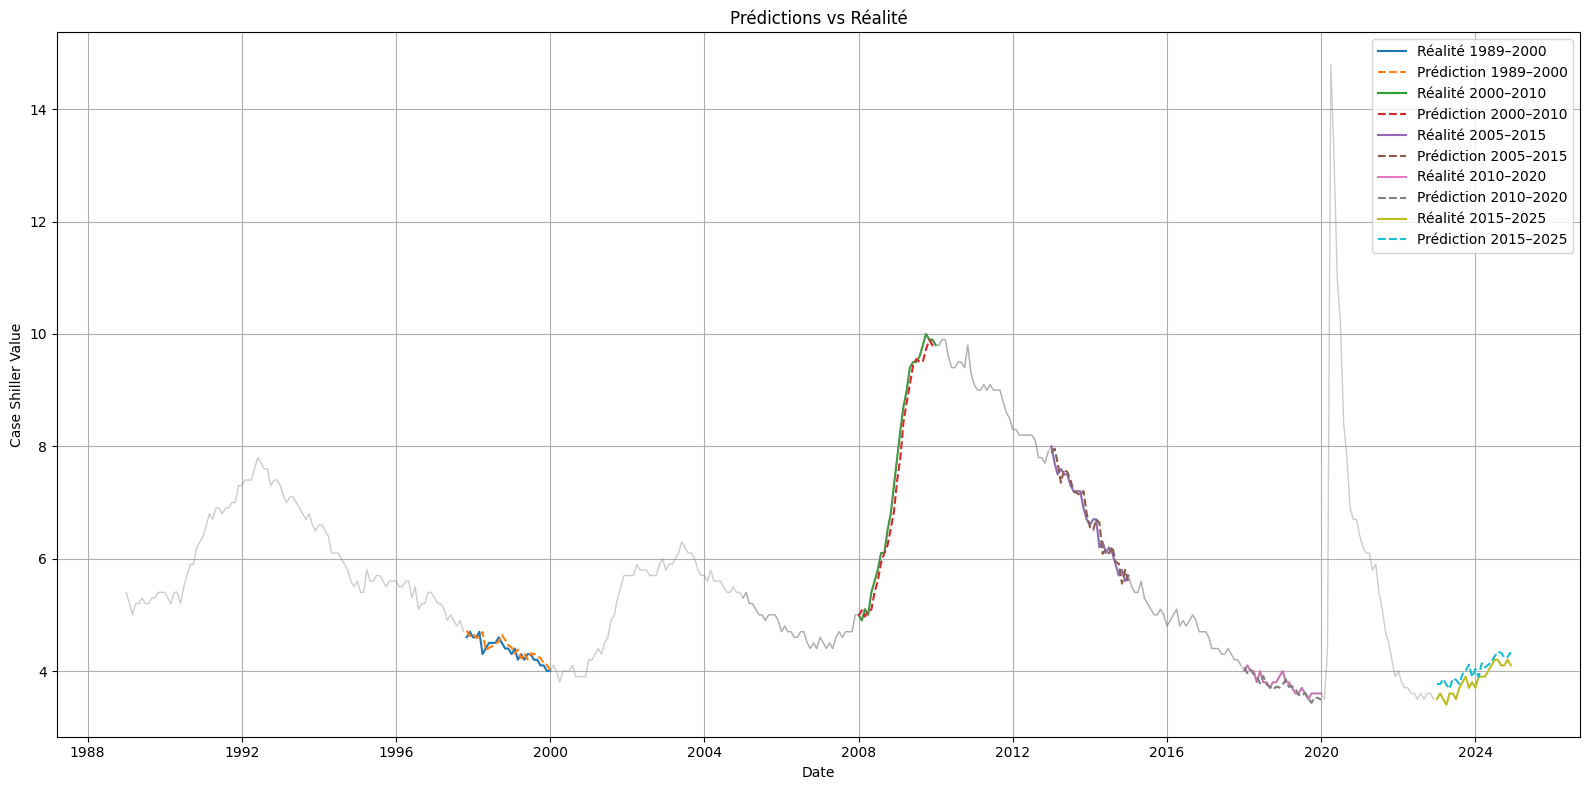

R² moyen du modèle : 0.6675
Taux de tendance moyen du modèle : 0.3731


In [23]:
# Préparation du DataFrame avec lags
df_temp = df_employment[["date", "fed_rate", "unemployment_rate", "personal_savings"]].copy()
df_temp["fed_rate_lag24"] = df_temp["fed_rate"].shift(24)

for lag in range(1, 25):
    df_temp[f"unemployment_rate_lag{lag}"] = df_temp["unemployment_rate"].shift(lag)

# Supprimer les lignes incomplètes
df_model = df_temp.dropna().reset_index(drop=True)

random_state = 42
# Set the random seed for reproducibility
np.random.seed(random_state)

# Liste pour stocker les R²
r2_scores_macro = []
trend_scores_macro = []

# Plot
plt.figure(figsize=(16, 8))
plt.title("Prédictions vs Réalité")
plt.xlabel("Date")
plt.ylabel("Case Shiller Value")

for start_date, end_date in periods:
    # Filtrage de la période
    period_df = df_model[(df_model["date"] >= start_date) & (df_model["date"] <= end_date)].copy()
    
    # Split train/test (80% train, 20% test)
    split_idx = int(len(period_df) * 0.8)
    train = period_df.iloc[:split_idx]
    test = period_df.iloc[split_idx:]

    # Y et X
    y_train = train["unemployment_rate"]
    X_train = train[[f"unemployment_rate_lag{lag}" for lag in range(1, 7)]]
    X_train = sm.add_constant(X_train)

    y_test = test["unemployment_rate"]
    X_test = test[[f"unemployment_rate_lag{lag}" for lag in range(1, 7)]]
    X_test = sm.add_constant(X_test)

    # Régression
    model = sm.OLS(y_train, X_train).fit()
    
    y_test_pred = model.predict(X_test)
    
    # Calcul du R² pour cette période
    r2 = r2_score(y_test, y_test_pred)
    r2_scores_macro.append(r2)
    trend_acc = trend_accuracy(y_test.values, y_test_pred.values)
    trend_scores_macro.append(trend_acc)

    # Tracés
    plt.plot(train["date"], y_train, color='gray', linewidth=1, alpha=0.4)
    plt.plot(test["date"], y_test, label=f"Réalité {start_date[:4]}–{end_date[:4]}")
    plt.plot(test["date"], y_test_pred, linestyle="--", label=f"Prédiction {start_date[:4]}–{end_date[:4]}")

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Moyenne du R² sur toutes les périodes
r2_model_unemp = np.mean(r2_scores_macro)
trend_model_unemp = np.mean(trend_scores_macro)
print(f"R² moyen du modèle : {r2_model_unemp:.4f}")
print(f"Taux de tendance moyen du modèle : {trend_model_unemp:.4f}")

/tmp/ipykernel_8520/553863919.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=15)
/tmp/ipykernel_8520/553863919.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=15)


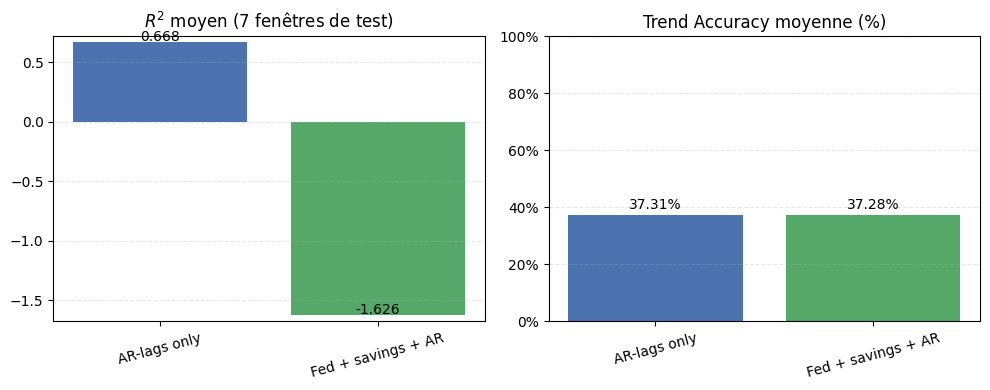

In [ ]:
# ──────────────────────────────────────────────────────────────
# Comparaison visuelle des métriques des deux modèles
# ──────────────────────────────────────────────────────────────

labels   = ["AR-lags only", "Fed + savings + AR"]
r2_vals  = [r2_model_unemp, r2_model_fed_pers_unemp]
ta_vals  = [trend_model_unemp, trend_model_fed_pers_unemp]

# --- figure -------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# --- sous-figure 1 : R² --------------------------------------------------
axes[0].bar(labels, r2_vals, color=["#4C72B0", "#55A868"])
axes[0].set_title("$R^{2}$ moyen (7 fenêtres de test)")
axes[0].set_ylim(min(r2_vals) - 0.05, max(r2_vals) + 0.05)
for i, v in enumerate(r2_vals):
    axes[0].text(i, v + 0.01, f"{v:.3f}", ha="center")

# --- sous-figure 2 : Trend Accuracy -------------------------------------
axes[1].bar(labels, ta_vals, color=["#4C72B0", "#55A868"])
axes[1].set_title("Trend Accuracy moyenne (%)")
axes[1].set_ylim(0, 1)
axes[1].set_yticks(np.linspace(0, 1, 6))
axes[1].set_yticklabels([f"{x:.0%}" for x in np.linspace(0, 1, 6)])
for i, v in enumerate(ta_vals):
    axes[1].text(i, v + 0.02, f"{v:.2%}", ha="center")

# --- mise en forme globale ---------------------------------------------
for ax in axes:
    ax.set_ylabel("")
    ax.set_xticklabels(labels, rotation=15)
    ax.grid(axis="y", alpha=0.3, linestyle="--")

fig.tight_layout()
plt.show()
